<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Amirhossein Mahmoudi
### Student Number : 98108779
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


C:\Users\HP OMEN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
torch.__version__


False

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [7]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


KeyboardInterrupt: 

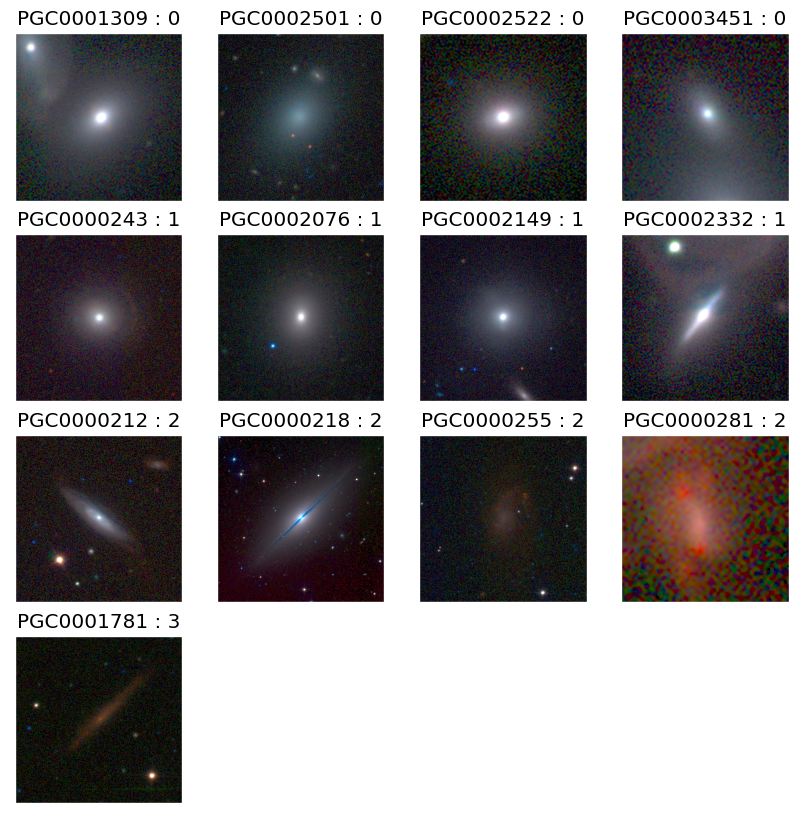

In [8]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
fig = plt.figure(figsize=(10,10)) # create a new figure window
import cv2
for i in range(4): # display 50 images
    # subplot : 5 rows and 10 columns
       
    class_members_name=list(df.loc[df['class_label']==i].pop('name'))
    
    #print(len(class_members_name))
    for j in range(4):
        image=cv2.imread(f'./efigi-1.6/png/{class_members_name[j]}.png')
        img_grid = fig.add_subplot(4, 4, (i)*4+j+1)
        img_grid.imshow(image)
        img_grid.set_yticks([])
        img_grid.set_xticks([])
        img_grid.set_title(class_members_name[j]+" : "+str(i))

plt.show()


# Define Dataset (20 Points)

In [ ]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################
import os
class GalaxyDataSet(Dataset):
    def __init__(self,data,rootDir):
        self.data=data
        self.rootDir=rootDir
        pass

    def __len__(self):
        return len(self.data)
        pass

    def __getitem__(self,idx):
        item=self.data.iloc[idx]
        item_name=item[0]
        item_class_name=item[1]
        item_class_label=item[2]
        item_add=os.path.join(self.root_dir, str(item_name)) + ".png"
        item_image=cv2.imread(item_add)
        sample={'id':idx , 'name':item_name, 'class_name':item_class_name, 'class_label':item_class_label, 'address':item_add, 'image':item_image}
        return sample

        
        pass

# Define Model (20 Points)

In [ ]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self,num_classes=4):
        super(ClassifierModel, self).__init__()
        # Convolutional and MaxPool layers
        self.conv1 = nn.Conv2d(3, 32, 6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
		# Dense layers
        self.fc1 = nn.Linear(128*2*2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        

    def forward(self, x):
        	# Convolutional and MaxPool layers 
        x = F.relu(self.conv1(x)) 
        x = self.pool1(x) 
        x = F.relu(self.conv2(x)) 
        x = self.pool2(x) 
        x = F.relu(self.conv3(x)) 
        x = F.relu(self.conv4(x)) 
        x = self.pool4(x)
		# Dense layers 
        x = x.view(-1, 128*2*2)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        return(x)

# Train Model (30 Points)

In [ ]:
VALIDATION_SPLIT=0.2
SHUFFLE_DS=True
RANDOM_SEED=22
BATCH_SIZE=100
NUM_EPOCHS = 5
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

dataset=GalaxyDataSet(df,'./efigi-1.6/png/')
size=len(dataset)
indices=list(range(size))
split = int(np.floor(VALIDATION_SPLIT * size))
if SHUFFLE_DS:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler   = SubsetRandomSampler(val_indices)

train_dl = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=16,
                                                 sampler=train_sampler)
val_dl = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=16,
                                                 sampler=val_sampler)
print("Total: {} Train_dl: {} Validation_dl: {}".format(size, len(train_dl),
                                                              len(val_dl)))
model=ClassifierModel(4)
print("Creating", "model")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.4, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)




#train
import time
def train_phase():
    model.train()
    losses = []
    epoch_start = time.time()
    for i, batch in enumerate(train_dl):
        inputs, labels = batch['image'], batch['class_label'].float().view(-1,4)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()             # 1. Zero the parameter gradients
        outputs = model(inputs)           # 2. Run the model

        loss = criterion(outputs, labels) # 3. Calculate loss
        losses.append(loss.item())
        loss = torch.sqrt(loss)           #    -> RMSE loss
        loss.backward()                   # 4. Backward propagate the loss
        optimizer.step()                  # 5. Optimize the network
        
        print("--> Batch {}/{} Loss: {}".format(i+1, len(train_dl), loss.item()))
        
    epoch_loss = np.sqrt(sum(losses) / len(losses))
    epoch_time = time.time() - epoch_start
    print("[TST] Epoch: {} Loss: {} Time: {:.0f}:{:.0f}".format(i+1, epoch_loss,
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss



Total: 4458 Train_dl: 36 Validation_dl: 9
Creating model


In [ ]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
train_losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train_phase()
    train_losses.append(train_loss)
 


# Test Model (20)

In [ ]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
def validate_phase():
    model.eval()
    losses = []
    epoch_start = time.time()
    for i, batch in enumerate(val_dl):
        inputs, labels = batch['image'], batch['class_label'].float().view(-1,4)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)           # 2. Run the model

        loss = criterion(outputs, labels) # 3. Calculate loss
        losses.append(loss.item())
        loss = torch.sqrt(loss)           #    -> RMSE loss
        
        #print("--> Batch {}/{} Loss: {}".format(i+1, len(train_dl), loss.item()))
        
    epoch_loss = np.sqrt(sum(losses) / len(losses))
    epoch_time = time.time() - epoch_start
    print("[VAL] Epoch: {} Loss: {} Time: {:.0f}:{:.0f}".format(i+1, epoch_loss,
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss



In [ ]:

val_losses = []
for epoch in range(NUM_EPOCHS):
    
    val_loss   = validate_phase()
    scheduler.step(val_loss)    
    val_losses.append(val_loss)

In [ ]:
MODEL_FILENAME="A.pt"
torch.save(model, MODEL_FILENAME)